100%|██████████| 26.4M/26.4M [00:01<00:00, 18.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 339kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.21MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 4.12MB/s]


Data ready: Train=54000, Val=6000, Test=10000
Training ANN...
[ANN] Epoch 1/10 | Loss=0.7811 | Train Acc=0.7188 | Val Acc=0.7850
[ANN] Epoch 2/10 | Loss=0.6251 | Train Acc=0.7826 | Val Acc=0.8092
[ANN] Epoch 3/10 | Loss=0.5958 | Train Acc=0.7922 | Val Acc=0.7870
[ANN] Epoch 4/10 | Loss=0.5915 | Train Acc=0.7983 | Val Acc=0.8172
[ANN] Epoch 5/10 | Loss=0.5717 | Train Acc=0.8031 | Val Acc=0.8162
[ANN] Epoch 6/10 | Loss=0.5602 | Train Acc=0.8083 | Val Acc=0.8213
[ANN] Epoch 7/10 | Loss=0.5428 | Train Acc=0.8149 | Val Acc=0.8285
[ANN] Epoch 8/10 | Loss=0.5411 | Train Acc=0.8166 | Val Acc=0.8265
[ANN] Epoch 9/10 | Loss=0.5351 | Train Acc=0.8163 | Val Acc=0.8230
[ANN] Epoch 10/10 | Loss=0.5266 | Train Acc=0.8207 | Val Acc=0.8335


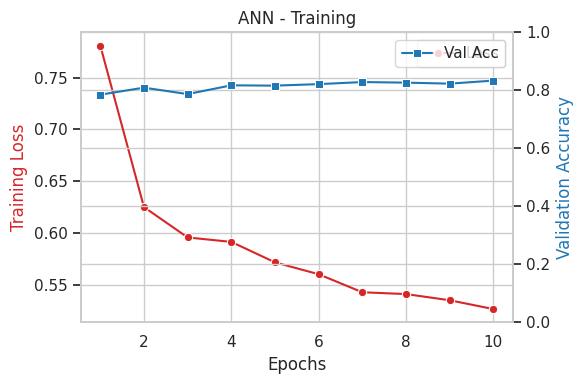


[ANN] Test Accuracy: 83.55%


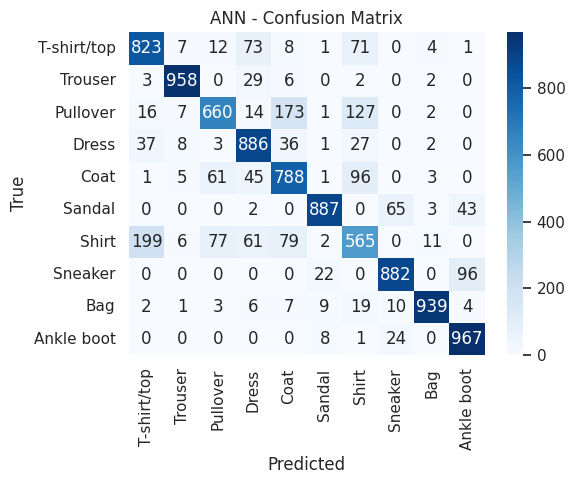



Training CNN...
[CNN] Epoch 1/10 | Loss=0.6089 | Train Acc=0.7784 | Val Acc=0.8377
[CNN] Epoch 2/10 | Loss=0.4855 | Train Acc=0.8248 | Val Acc=0.8420
[CNN] Epoch 3/10 | Loss=0.4498 | Train Acc=0.8383 | Val Acc=0.8583
[CNN] Epoch 4/10 | Loss=0.4262 | Train Acc=0.8452 | Val Acc=0.8577
[CNN] Epoch 5/10 | Loss=0.4262 | Train Acc=0.8473 | Val Acc=0.8590
[CNN] Epoch 6/10 | Loss=0.4116 | Train Acc=0.8521 | Val Acc=0.8538
[CNN] Epoch 7/10 | Loss=0.4108 | Train Acc=0.8522 | Val Acc=0.8557
[CNN] Epoch 8/10 | Loss=0.4078 | Train Acc=0.8528 | Val Acc=0.8567
[CNN] Epoch 9/10 | Loss=0.3990 | Train Acc=0.8559 | Val Acc=0.8598
[CNN] Epoch 10/10 | Loss=0.3975 | Train Acc=0.8567 | Val Acc=0.8600


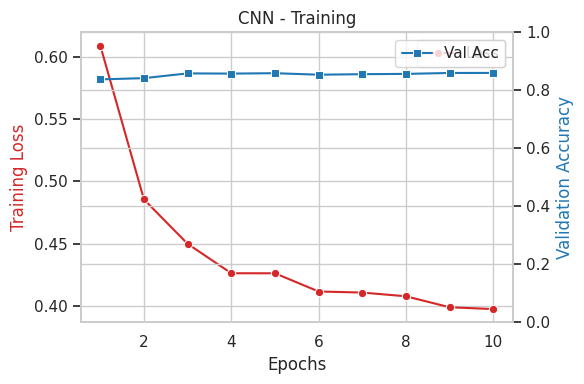


[CNN] Test Accuracy: 86.35%


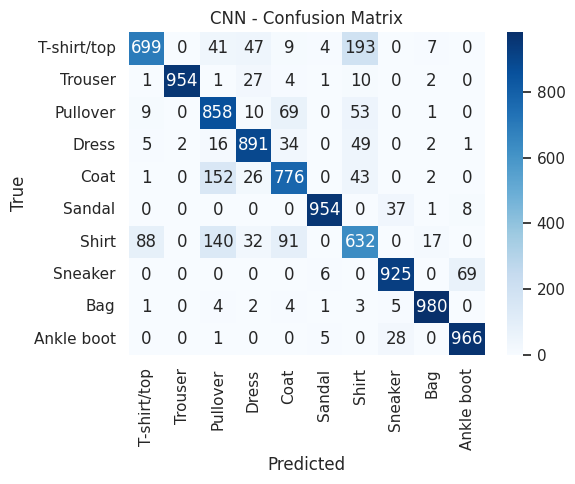

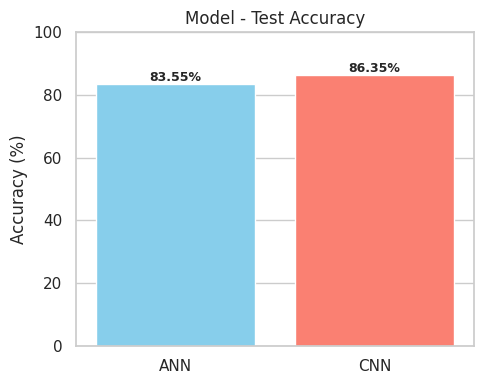


=== Summary ===
ANN Test Accuracy: 83.55%
CNN Test Accuracy: 86.35%


In [ ]:
# ==================================
# 0. Setup and Hyperparameters
# ==================================
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration  ---
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH = 64
EPOCHS = 10
LR = 0.05
MOM = 0.9
VAL_SPLIT = 0.1
CLASS_LABELS = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
DROP_RATE = 0.4

# ===========================
# 1. Data Preparation
# ===========================
def prepare_data(val_ratio=VAL_SPLIT, batch_size=BATCH):
    transform_train = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_full = torchvision.datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=transform_train
    )
    test_dataset = torchvision.datasets.FashionMNIST(
        root='./data', train=False, download=True, transform=transform_test
    )

    val_size = int(len(train_full) * val_ratio)
    train_size = len(train_full) - val_size
    train_subset, val_subset = random_split(train_full, [train_size, val_size])

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Data ready: Train={train_size}, Val={val_size}, Test={len(test_dataset)}")
    return train_loader, val_loader, test_loader

# ==============================
# 2. Model Definitions
# ==============================
class ANN_Model(nn.Module):
    def __init__(self):
        super(ANN_Model, self).__init__()
        self.layer1 = nn.Linear(28*28, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 10)
        self.drop = nn.Dropout(DROP_RATE)
        self.act = F.relu

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.act(self.layer1(x))
        x = self.drop(self.act(self.layer2(x)))
        x = self.layer3(x)
        return x

class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.drop = nn.Dropout(DROP_RATE)
        self.fc1 = nn.Linear(16*14*14, 32)
        self.fc2 = nn.Linear(32, 10)
        self.act = F.relu

    def forward(self, x):
        x = self.pool(self.act(self.conv(x)))
        x = self.drop(x)
        x = x.view(-1, 16*14*14)
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        return x

# ==================================
# 3. Training and Evaluation
# ==================================
def compute_accuracy(model, loader, device=DEVICE):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs)
            _, pred = torch.max(out.data, 1)
            total += lbls.size(0)
            correct += (pred == lbls).sum().item()
    return correct / total

def train_network(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, mom=MOM, name="Model", device=DEVICE):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mom)
    loss_list, val_acc_list = [], []
    best_val = 0.0

    print(f"Training {name}...")

    for ep in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for batch_idx, (imgs, lbls) in enumerate(train_loader):
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            total += lbls.size(0)
            correct += (pred == lbls).sum().item()

        train_acc = correct / total
        val_acc = compute_accuracy(model, val_loader)
        loss_avg = running_loss / len(train_loader)
        loss_list.append(loss_avg)
        val_acc_list.append(val_acc)
        print(f"[{name}] Epoch {ep+1}/{epochs} | Loss={loss_avg:.4f} | Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f}")

        if val_acc > best_val:
            best_val = val_acc

    return loss_list, val_acc_list

def evaluate_network(model, loader, labels, name, device=DEVICE):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            if name.endswith("ANN"):
                out = model(imgs.view(imgs.size(0), -1))
            else:
                out = model(imgs)
            _, preds = torch.max(out.data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    print(f"\n[{name}] Test Accuracy: {acc*100:.2f}%")
    return acc, cm

# ==================================
# 4. Visualization Functions
# ==================================
sns.set_theme(style="whitegrid")

def plot_training(losses, val_accs, name):
    epochs = range(1, len(losses)+1)
    fig, ax1 = plt.subplots(figsize=(6,4))
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Training Loss", color='tab:red')
    sns.lineplot(x=epochs, y=losses, ax=ax1, color='tab:red', marker='o', label='Loss')
    ax2 = ax1.twinx()
    ax2.set_ylabel("Validation Accuracy", color='tab:blue')
    sns.lineplot(x=epochs, y=val_accs, ax=ax2, color='tab:blue', marker='s', label='Val Acc')
    ax2.set_ylim(0,1.0)
    plt.title(f"{name} - Training")
    plt.tight_layout()
    plt.savefig(f"{name}_training.png")
    plt.show()
    plt.close(fig)

def plot_conf_matrix(cm, classes, name):
    fig = plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{name}_confusion.png")
    plt.show()
    plt.close(fig)


    print("\n" + "="*60 + "\n")

def plot_accuracy_comparison(acc_ann, acc_cnn, title="Model Comparison"):
    models = ['ANN', 'CNN']
    accuracies = [acc_ann*100, acc_cnn*100]

    fig = plt.figure(figsize=(5,4))
    sns.barplot(x=models, y=accuracies, palette=None)
    bars = plt.gca().patches
    bars[0].set_facecolor('skyblue')
    bars[1].set_facecolor('salmon')
    plt.ylim(0,100)
    plt.title(f"{title} - Test Accuracy")
    plt.ylabel("Accuracy (%)")
    for i, a in enumerate(accuracies):
        plt.text(i, a+1, f"{a:.2f}%", ha='center', fontsize=9, weight='bold')
    plt.tight_layout()
    plt.savefig(f"{title}_comparison.png")
    plt.show()
    plt.close(fig)

# =============================
# 5. Main Execution
# =============================
if __name__ == '__main__':
    train_loader, val_loader, test_loader = prepare_data()

    # --- Train ANN ---
    ann_net = ANN_Model()
    ann_losses, ann_val_accs = train_network(ann_net, train_loader, val_loader, name="ANN")
    plot_training(ann_losses, ann_val_accs, "ANN")
    ann_accuracy, ann_cm = evaluate_network(ann_net, test_loader, CLASS_LABELS, "ANN")
    plot_conf_matrix(ann_cm, CLASS_LABELS, "ANN")

    # --- Train CNN ---
    cnn_net = CNN_Model()
    cnn_losses, cnn_val_accs = train_network(cnn_net, train_loader, val_loader, name="CNN")
    plot_training(cnn_losses, cnn_val_accs, "CNN")
    cnn_accuracy, cnn_cm = evaluate_network(cnn_net, test_loader, CLASS_LABELS, "CNN")
    plot_conf_matrix(cnn_cm, CLASS_LABELS, "CNN")

    # --- Compare ---
    plot_accuracy_comparison(ann_accuracy, cnn_accuracy, "Model")

    print("\n=== Summary ===")
    print(f"ANN Test Accuracy: {ann_accuracy*100:.2f}%")
    print(f"CNN Test Accuracy: {cnn_accuracy*100:.2f}%")
